In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Define the fitting models

In [2]:
# Define a general hyperbolic tangent model
def area_tanh(t, a, b, c, d):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    return a*np.tanh(b*(t-c))+d

# Define the logistic growth rate model
def area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    return k*a0 / (a0 + (k-a0)*np.exp(-r*t))

### Read the data frame and show a summary of the growth curves and the fitting models

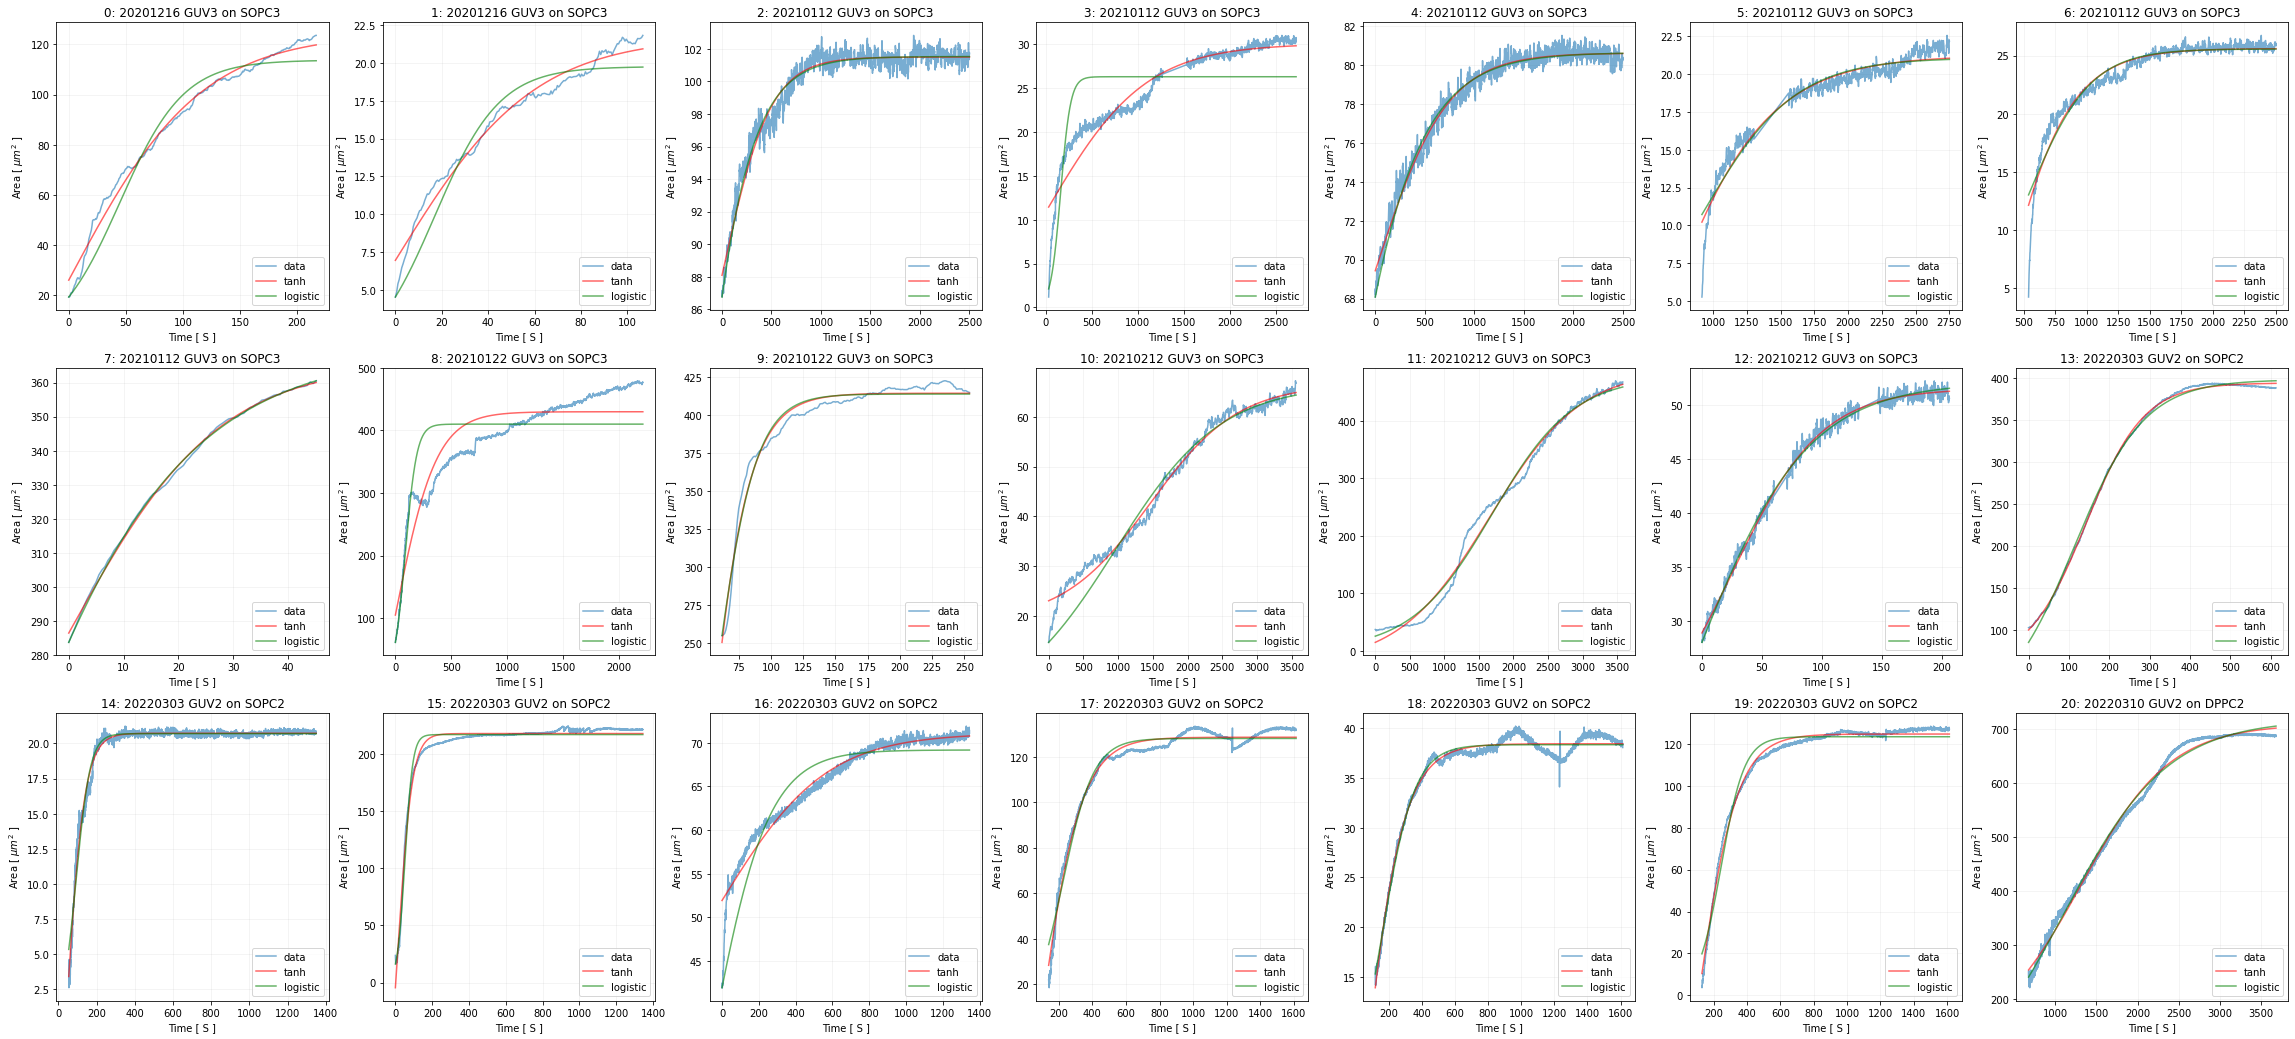

In [3]:
df = pd.read_pickle('Results/initial_area_curves.pkl')

parameters_tanh, parameters_logistic = [], []
for i in range(21):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Fit a general tanh function to the curves 
    popt_tanh, _ = curve_fit(area_tanh, t, A, p0=(np.max(A)-np.min(A), 0.01, 0, 0), bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))
    parameters_tanh.append(popt_tanh)
                   
    # Fit a general tanh function to the curves 
    popt_logistic, _ = curve_fit(area_logistic, t, A, p0=(1, 0.01, np.max(A)), bounds=([0.1, 0.00001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))
    parameters_logistic.append(popt_logistic)
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(40, 18))
    
    plt.subplot(3, 7, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')
    
plt.savefig('Results/initial_area_curves_2')

In [4]:
# Save the initial data frame with proper name
df.to_pickle('Results/initial_area_curves_2.pkl')

# Add columns for the model to the data frame
df['Model_tanh'] = parameters_tanh
df['Model_logistic'] = parameters_logistic

# Save the results data frame as pickle
df.to_pickle('Results/result_area_curves_2.pkl')

# Save a csv and excel to be used out of python
df.drop(['Time', 'Area'], axis=1).to_csv('Results/result_area_curves_2.csv', index=False)
df.drop(['Time', 'Area'], axis=1).to_excel('Results/result_area_curves_2.xlsx', index=False)

df

,Date,Protein,Discription,Name,Time,Area,Model_tanh,Model_logistic
0,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera1and2-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[19.203125, 19.15625, 19.484375, 20.359375, 20...","[98.48163052711078, 0.008634148156220817, 1.04...","[19.156249999999996, 0.035715181431460345, 113..."
1,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera3-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[4.53125, 4.859375, 5.40625, 5.6875, 6.078125,...","[14.779843051718007, 0.01672230062303314, 3.35...","[4.531249999999999, 0.07143526289282906, 19.75..."
2,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[87.140625, 86.953125, 86.765625, 86.75, 86.93...","[13.415873486153279, 0.00205862208961621, 3.68...","[86.74999999999928, 0.003457313729396933, 101...."
3,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-2,"[33.0, 33.55, 34.1, 34.65, 35.2, 35.75, 36.3, ...","[1.1875, 1.28125, 1.25, 1.59375, 1.765625, 2.0...","[19.219767465894414, 0.000925842460984089, 1.7...","[1.1874999999999998, 0.018662181180585297, 26...."
4,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[68.078125, 68.203125, 68.515625, 68.34375, 68...","[11.177891987580095, 0.001386804352269946, 2.8...","[68.07812499999999, 0.0023799207420860283, 80...."
5,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-4,"[916.0, 917.0, 918.0, 919.0, 920.0, 921.0, 922...","[5.265625, 5.40625, 5.515625, 5.875, 6.0625, 6...","[22.562499999999993, 0.0011887206923075337, 44...","[1.4681363342001887, 0.0028673806999220965, 21..."
6,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-5,"[537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 543...","[4.265625, 4.859375, 5.3125, 5.96875, 6.203125...","[26.734374999999996, 0.0017744834127692627, 23...","[2.7318889909842667, 0.0040280423089972565, 25..."
7,20210112,Mouse Ecad,GUV3 on SOPC3,movie-550ms-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[283.78125, 285.921875, 287.90625, 290.109375,...","[79.26193465299644, 0.03633559487253107, 6.991...","[283.78124999999994, 0.05486956828001781, 369...."
8,20210122,Mouse Ecad,GUV3 on SOPC3,movie-1200-100ms-600-1sec-300-1sec-1200-1sec-1,"[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6000000000000...","[61.4375, 61.609375, 61.90625, 62.171875, 62.2...","[324.6148951105918, 0.002738372222105698, 3.25...","[61.43749999999352, 0.019519096598718994, 409...."
9,20210122,Mouse Ecad,GUV3 on SOPC3,movie-1200-3sec-1,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...","[254.59375, 255.1875, 256.03125, 258.53125, 26...","[422.7499999999981, 0.02722657641248094, 35.88...","[13.81644139741513, 0.0618717278125737, 413.97..."


In [5]:
for i, parameter in enumerate(parameters_tanh):
    print(i, ' --> {:.1f} tanh[{:.1e} (t - {:.1e})] + {:.1f}'.format(*parameter))

0  --> 98.5 tanh[8.6e-03 (t - 1.0e-19)] + 25.9
1  --> 14.8 tanh[1.7e-02 (t - 3.4e-24)] + 7.0
2  --> 13.4 tanh[2.1e-03 (t - 3.7e-10)] + 88.1
3  --> 19.2 tanh[9.3e-04 (t - 1.7e-19)] + 10.9
4  --> 11.2 tanh[1.4e-03 (t - 2.9e-11)] + 69.4
5  --> 22.6 tanh[1.2e-03 (t - 4.4e+02)] + -1.3
6  --> 26.7 tanh[1.8e-03 (t - 2.3e+02)] + -1.1
7  --> 79.3 tanh[3.6e-02 (t - 7.0e-14)] + 286.5
8  --> 324.6 tanh[2.7e-03 (t - 3.3e-58)] + 105.1
9  --> 422.7 tanh[2.7e-02 (t - 3.6e+01)] + -8.2
10  --> 24.0 tanh[7.9e-04 (t - 1.5e+03)] + 42.6
11  --> 257.2 tanh[7.6e-04 (t - 1.7e+03)] + 233.1
12  --> 17.0 tanh[1.3e-02 (t - 2.6e+01)] + 34.5
13  --> 167.2 tanh[7.0e-03 (t - 1.4e+02)] + 226.6
14  --> 21.2 tanh[1.0e-02 (t - 3.6e+01)] + -0.5
15  --> 186.5 tanh[1.3e-02 (t - 1.5e+01)] + 31.5
16  --> 19.2 tanh[1.8e-03 (t - 2.4e-13)] + 51.9
17  --> 133.7 tanh[4.1e-03 (t - 7.7e+01)] + -4.9
18  --> 40.2 tanh[4.0e-03 (t - 1.6e+01)] + -1.8
19  --> 128.5 tanh[4.3e-03 (t - 1.0e+02)] + -3.8
20  --> 297.7 tanh[9.2e-04 (t - 1.3e+03)

In [6]:
for i, parameter in enumerate(parameters_logistic):
    print(i, 'A0 = {:.1f}, r = {:.5f}, k = {:.1f}'.format(*parameter))

0 A0 = 19.2, r = 0.03572, k = 113.7
1 A0 = 4.5, r = 0.07144, k = 19.8
2 A0 = 86.7, r = 0.00346, k = 101.5
3 A0 = 1.2, r = 0.01866, k = 26.3
4 A0 = 68.1, r = 0.00238, k = 80.6
5 A0 = 1.5, r = 0.00287, k = 21.1
6 A0 = 2.7, r = 0.00403, k = 25.6
7 A0 = 283.8, r = 0.05487, k = 369.7
8 A0 = 61.4, r = 0.01952, k = 409.9
9 A0 = 13.8, r = 0.06187, k = 414.0
10 A0 = 14.7, r = 0.00132, k = 66.5
11 A0 = 25.4, r = 0.00170, k = 477.9
12 A0 = 28.0, r = 0.02129, k = 52.1
13 A0 = 84.9, r = 0.01151, k = 397.8
14 A0 = 1.6, r = 0.02707, k = 20.7
15 A0 = 16.3, r = 0.04777, k = 217.1
16 A0 = 42.0, r = 0.00642, k = 69.2
17 A0 = 10.7, r = 0.01079, k = 128.2
18 A0 = 6.4, r = 0.01011, k = 38.4
19 A0 = 3.6, r = 0.01430, k = 123.5
20 A0 = 107.0, r = 0.00158, k = 717.8
